# Models > Random Forest

<div class="alert alert-info">Estimate and tune a Random Forest model for binary classification</div>

In [1]:
import os
import numpy as np
import pandas as pd
import pyrsm as rsm
import matplotlib as mpl
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# increase plot resolution
mpl.rcParams["figure.dpi"] = 100

In [2]:
# needs pyrsm version 1.0.4 or higher
# update using pip install --user pyrsm --upgrade
rsm.__version__

'1.3.0'

In [3]:
## setup pyrsm for autoreload
%reload_ext autoreload
%autoreload 2
%aimport pyrsm

### Example

As an example we will use a dataset that describes the survival status of individual passengers on the Titanic. The principal source for data about Titanic passengers is the Encyclopedia Titanic. One of the original sources is Eaton & Haas (1994) Titanic: Triumph and Tragedy, Patrick Stephens Ltd, which includes a passenger list created by many researchers and edited by Michael A. Findlay. Suppose we want to investigate which factors are most strongly associated with the chance of surviving the sinking of the Titanic. Lets focus on four variables in the database:

- survived = a factor with levels `Yes` and `No`
- pclass = Passenger Class (1st, 2nd, 3rd). This is a proxy for socio-economic status (SES) 1st ~ Upper; 2nd ~ Middle; 3rd ~ Lower
- sex = Sex (female, male)
- age = Age in years

Select `survived` as the response variable and `Yes` in **Choose level**. Select `pclass`, `sex` and `age` as the explanatory variables. In contrast to Logistic Regression, a Machine Learning model like a Random Forest does not provide coefficients or odds-ratios that we can interpret. Instead, the model provides predictions that we need to evaluate for accuracy. We will also use different plots to better understand what the Random Forest model is telling us about the connection between the explanatory variables (i.e., features) and the response variable (i.e., target).


In [4]:
titanic, titanic_description = rsm.load_data(pkg="data", name="titanic")
titanic

,pclass,survived,sex,age,sibsp,parch,fare,name,cabin,embarked
0,1st,Yes,female,29.0000,0,0,211.337494,"Allen, Miss. Elisabeth Walton",B5,Southampton
1,1st,Yes,male,0.9167,1,2,151.550003,"Allison, Master. Hudson Trevor",C22 C26,Southampton
2,1st,No,female,2.0000,1,2,151.550003,"Allison, Miss. Helen Loraine",C22 C26,Southampton
3,1st,No,male,30.0000,1,2,151.550003,"Allison, Mr. Hudson Joshua Crei",C22 C26,Southampton
4,1st,No,female,25.0000,1,2,151.550003,"Allison, Mrs. Hudson J C (Bessi",C22 C26,Southampton
...,...,...,...,...,...,...,...,...,...,...
1038,3rd,No,male,45.5000,0,0,7.225000,"Youseff, Mr. Gerious",,Cherbourg
1039,3rd,No,female,14.5000,1,0,14.454200,"Zabour, Miss. Hileni",,Cherbourg
1040,3rd,No,male,26.5000,0,0,7.225000,"Zakarian, Mr. Mapriededer",,Cherbourg
1041,3rd,No,male,27.0000,0,0,7.225000,"Zakarian, Mr. Ortin",,Cherbourg


In [5]:
rsm.md(titanic_description)

## Titanic

This dataset describes the survival status of individual passengers on the Titanic. The titanic data frame does not contain information from the crew, but it does contain actual ages of (some of) the passengers. The principal source for data about Titanic passengers is the Encyclopedia Titanica. One of the original sources is Eaton & Haas (1994) Titanic: Triumph and Tragedy, Patrick Stephens Ltd, which includes a passenger list created by many researchers and edited by Michael A. Findlay.

## Variables

* survival - Survival (Yes, No)
* pclass - Passenger Class (1st, 2nd, 3rd)
* sex - Sex (female, male)
* age - Age in years
* sibsp - Number of Siblings/Spouses Aboard
* parch - Number of Parents/Children Aboard
* fare - Passenger Fare
* name - Name
* cabin - Cabin
* embarked - Port of Embarkation (Cherbourg, Queenstown, Southampton)

##  Notes

`pclass` is a proxy for socio-economic status (SES) 1st ~ Upper; 2nd ~ Middle; 3rd ~ Lower

Age is in Years; Fractional if Age less than One (1). If the Age is Estimated, it is in the form xx.5

With respect to the family relation variables (i.e. sibsp and parch) some relations were ignored.  The following are the definitions used for sibsp and parch.

Sibling:  Brother, Sister, Stepbrother, or Stepsister of Passenger Aboard Titanic
Spouse:   Husband or Wife of Passenger Aboard Titanic (Mistresses and Fiances Ignored)
Parent:   Mother or Father of Passenger Aboard Titanic
Child:    Son, Daughter, Stepson, or Stepdaughter of Passenger Aboard Titanic

Other family relatives excluded from this study include cousins, nephews/nieces, aunts/uncles, and in-laws. Some children travelled only with a nanny, therefore parch=0 for them.  As well, some travelled with very close friends or neighbors in a village, however, the definitions do not support such relations.

Note: Missing values and the `ticket` variable were removed from the data

## Related reading

<a href="http://phys.org/news/2012-07-shipwrecks-men-survive.html" target="_blank">In shipwrecks, men more likely to survive</a>

In [6]:
titanic.head()

,pclass,survived,sex,age,sibsp,parch,fare,name,cabin,embarked
0,1st,Yes,female,29.0000,0,0,211.337494,"Allen, Miss. Elisabeth Walton",B5,Southampton
1,1st,Yes,male,0.9167,1,2,151.550003,"Allison, Master. Hudson Trevor",C22 C26,Southampton
2,1st,No,female,2.0000,1,2,151.550003,"Allison, Miss. Helen Loraine",C22 C26,Southampton
3,1st,No,male,30.0000,1,2,151.550003,"Allison, Mr. Hudson Joshua Crei",C22 C26,Southampton
4,1st,No,female,25.0000,1,2,151.550003,"Allison, Mrs. Hudson J C (Bessi",C22 C26,Southampton


In [7]:
clf_rf = rsm.model.rforest({"titanic": titanic}, rvar="survived", lev="Yes", evar=["pclass", "sex", "age"])
clf_rf.summary()

Random Forest
Data                 : titanic
Response variable    : survived
Level                : Yes
Explanatory variables: pclass, sex, age
OOB                  : True
Model type           : classification
Nr. of features      : (3, 5)
Nr. of observations  : 1,043
max_features         : sqrt (2)
n_estimators         : 100
min_samples_leaf     : 1
max_samples          : 1.0
random_state         : 1234
AUC                  : 0.827

Estimation data      :
    age  pclass_1st  pclass_2nd  pclass_3rd  sex_male
29.0000        True       False       False     False
 0.9167        True       False       False      True
 2.0000        True       False       False     False
30.0000        True       False       False      True
25.0000        True       False       False     False


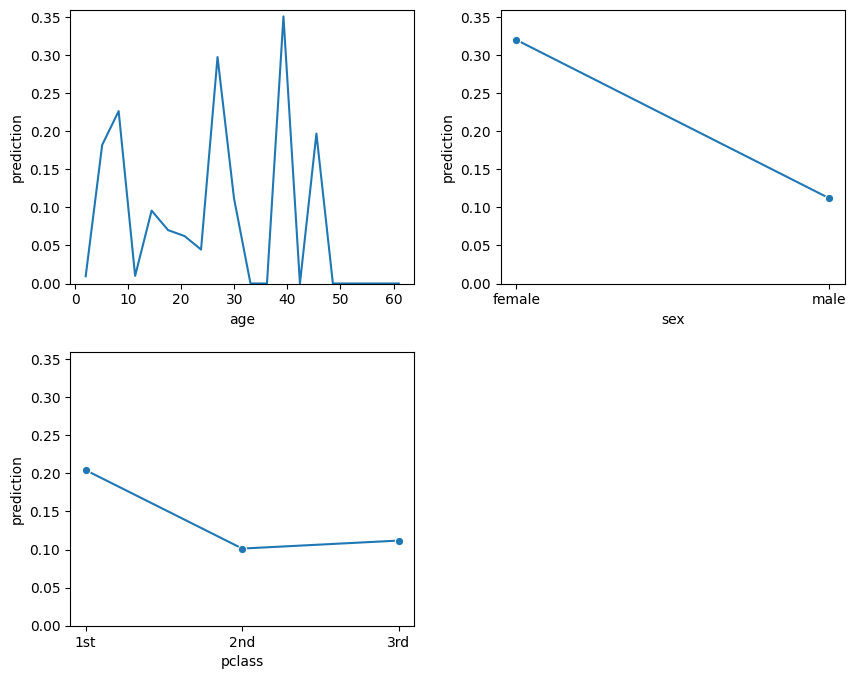

In [8]:
clf_rf.plot("pred")

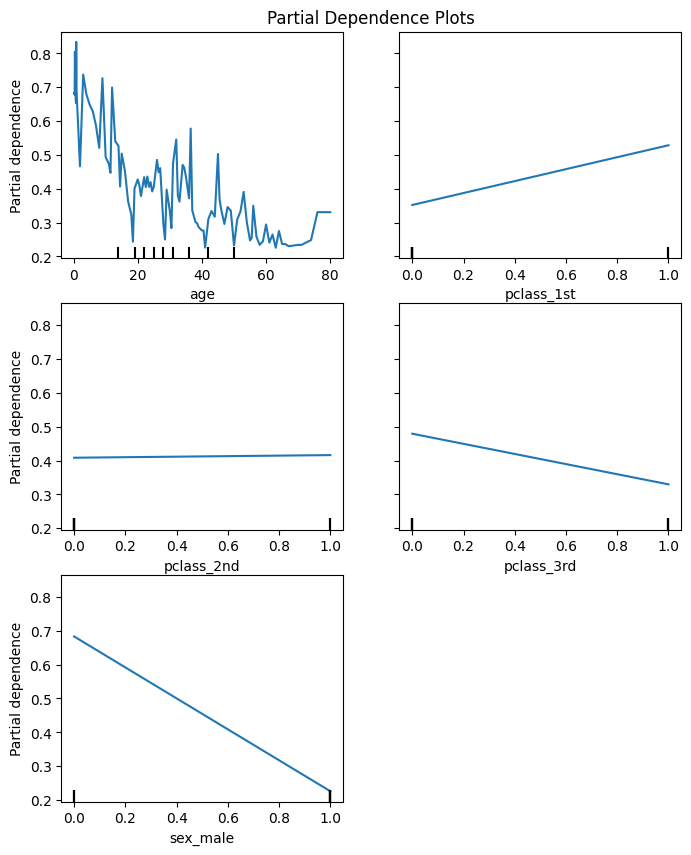

In [9]:
clf_rf.plot("pdp")

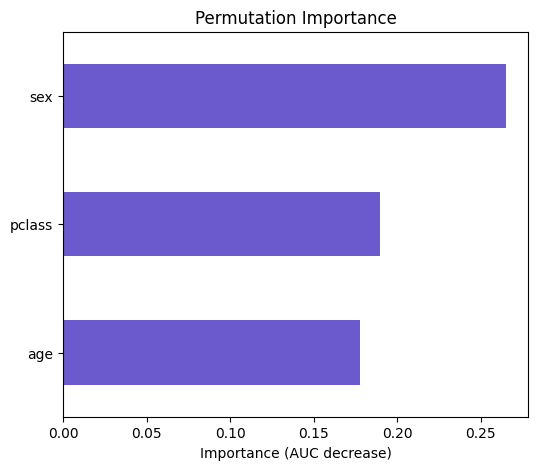

In [10]:
clf_rf.plot("vimp")

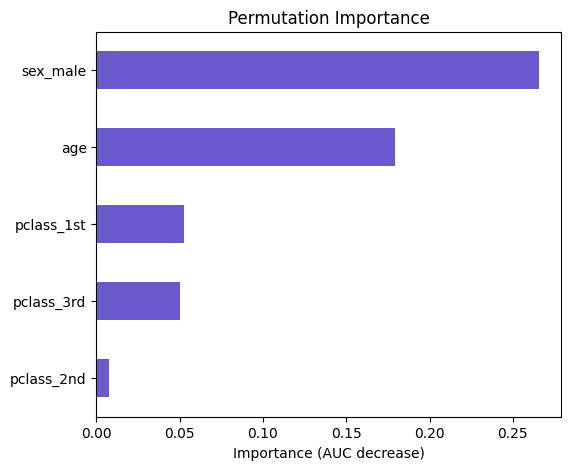

In [11]:
clf_rf.plot("vimp_sklearn")

In [12]:
clf_rf.predict()

,pclass,sex,age,prediction
0,1st,female,29.0000,1.000000
1,1st,male,0.9167,0.830952
2,1st,female,2.0000,0.954545
3,1st,male,30.0000,0.287177
4,1st,female,25.0000,1.000000
...,...,...,...,...
1038,3rd,male,45.5000,0.531982
1039,3rd,female,14.5000,0.612885
1040,3rd,male,26.5000,0.208959
1041,3rd,male,27.0000,0.327293


In addition to the numerical output provided in the _Summary_ tab we can also evaluate the link between `survival`, `class`, `sex`, and `age` visually (see _Plot_ tab). 


# Radiant for Python App: Random Forest - Classification

All the output shown above can be reproduced using the Radiant-for-Python web interface. An example of what the code required to start the web interface is shown below. See if you can reproduce the result.

> Note: The app will continue running until you press the `Stop` button in the app navigation bar or the stop button next to the notebook cell


In [13]:
# uncomment the line below if you want to use the radiant web interface
# rsm.radiant.model.rforest({"titanic": titanic}, {"titanic": titanic_description})

<p align="center">
<img src="figures/rf-classification-summary.png">
</p>

<p align="center">
<img src="figures/rf-classification-pred-plots.png">
</p>


## Tuning a Random Forest model

When building a Random Forest model, there are several hyperparameters that can be tuned to improve model performance. Two key parameters we'll focus on are:

- `max_features`: The number of features to consider for each split
- `n_estimators`: The number of trees in the forest

To find the optimal combination of these parameters, we'll:

1. Split our data into training (70%) and test (30%) sets
2. Use grid search with 5-fold cross validation to evaluate different parameter combinations
3. Compare model performance with default vs tuned parameters

First, let's create our train/test split:

In [14]:
titanic["training"] = rsm.make_train(titanic, strat_var="survived", test_size=0.3, random_state=1234)

In [15]:
clf_rf = rsm.model.rforest(
    data={"titanic (train)": titanic[titanic.training == 1]},
    rvar="survived",
    lev="Yes",
    evar=["pclass", "sex", "age"],
    max_features=2,
    n_estimators=100,
)
clf_rf.summary()

Random Forest
Data                 : titanic (train)
Response variable    : survived
Level                : Yes
Explanatory variables: pclass, sex, age
OOB                  : True
Model type           : classification
Nr. of features      : (3, 5)
Nr. of observations  : 730
max_features         : 2 (2)
n_estimators         : 100
min_samples_leaf     : 1
max_samples          : 1.0
random_state         : 1234
AUC                  : 0.81

Estimation data      :
    age  pclass_1st  pclass_2nd  pclass_3rd  sex_male
 0.9167        True       False       False      True
 2.0000        True       False       False     False
25.0000        True       False       False     False
53.0000        True       False       False     False
47.0000        True       False       False      True


In [16]:
titanic["pred_rf"] = clf_rf.predict(titanic)["prediction"]
titanic

,pclass,survived,sex,age,sibsp,parch,fare,name,cabin,embarked,training,pred_rf
0,1st,Yes,female,29.0000,0,0,211.337494,"Allen, Miss. Elisabeth Walton",B5,Southampton,0.0,1.000000
1,1st,Yes,male,0.9167,1,2,151.550003,"Allison, Master. Hudson Trevor",C22 C26,Southampton,1.0,0.960000
2,1st,No,female,2.0000,1,2,151.550003,"Allison, Miss. Helen Loraine",C22 C26,Southampton,1.0,0.287857
3,1st,No,male,30.0000,1,2,151.550003,"Allison, Mr. Hudson Joshua Crei",C22 C26,Southampton,0.0,0.025000
4,1st,No,female,25.0000,1,2,151.550003,"Allison, Mrs. Hudson J C (Bessi",C22 C26,Southampton,1.0,0.400000
...,...,...,...,...,...,...,...,...,...,...,...,...
1038,3rd,No,male,45.5000,0,0,7.225000,"Youseff, Mr. Gerious",,Cherbourg,1.0,0.130952
1039,3rd,No,female,14.5000,1,0,14.454200,"Zabour, Miss. Hileni",,Cherbourg,0.0,0.562857
1040,3rd,No,male,26.5000,0,0,7.225000,"Zakarian, Mr. Mapriededer",,Cherbourg,1.0,0.076258
1041,3rd,No,male,27.0000,0,0,7.225000,"Zakarian, Mr. Ortin",,Cherbourg,1.0,0.293657


There is something interesting happening in the graph below. Compare this graph with the next one which seems to have no overfitting. The issue is connected to OOB. Use Advanced Voice Mode in ChatGPT to have a discussion about OOB and overfitting in Random Forest models.

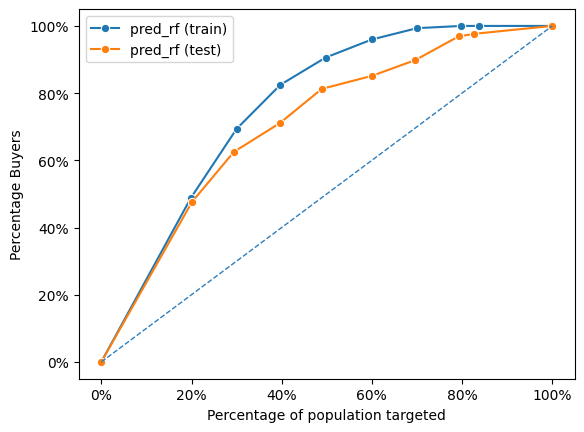

In [17]:
dct = {
    "train": titanic[titanic.training == 1],
    "test": titanic[titanic.training == 0],
}
fig = rsm.gains_plot(dct, rvar="survived", lev="Yes", pred="pred_rf")

In [18]:
titanic.loc[titanic.training == 1, "pred_rf"] = clf_rf.predict()["prediction"]

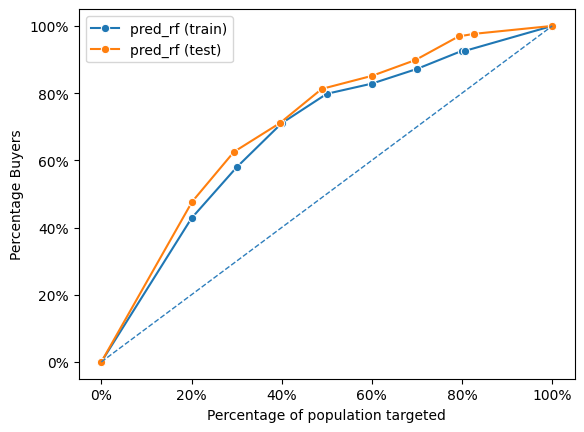

In [19]:
dct = {
    "train": titanic[titanic.training == 1],
    "test": titanic[titanic.training == 0],
}
fig = rsm.gains_plot(dct, rvar="survived", lev="Yes", pred="pred_rf")

The initial model used default parameters. Let's evaluate different combinations of parameters using grid search cross validation. We'll try:

- max_features: 1 to 5 features
- n_estimators: 100 to 500 trees (in steps of 100)

We'll use the AUC (Area Under the ROC Curve) metric to evaluate performance:

In [20]:
param_grid = {"max_features": list(range(1, 6)), "n_estimators": np.arange(100, 600, 100)}
scoring = {"AUC": "roc_auc"}
param_grid

{'max_features': [1, 2, 3, 4, 5],
 'n_estimators': array([100, 200, 300, 400, 500])}

In [21]:
cv_file = "cv-objects/clf-rf-cross-validation-object.pkl"
if os.path.exists(cv_file):
    cv = rsm.load_state(cv_file)["cv"]
else:
    stratified_k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1234)
    cv = GridSearchCV(
        clf_rf.fitted,
        param_grid,
        scoring=scoring,
        cv=stratified_k_fold,
        n_jobs=4,
        refit=list(scoring.keys())[0],
        verbose=5,
    ).fit(clf_rf.data_onehot, clf_rf.data.survived)
    if not os.path.exists("cv-objects"):
        os.mkdir("cv-objects")
    rsm.save_state({"cv": cv}, cv_file)

In [22]:
cv.best_params_

{'max_features': 2, 'n_estimators': np.int64(300)}

In [23]:
cv.best_score_

np.float64(0.7947960982063166)

In [24]:
pd.DataFrame(cv.cv_results_).sort_values("rank_test_AUC").head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,params,split0_test_AUC,split1_test_AUC,split2_test_AUC,split3_test_AUC,split4_test_AUC,mean_test_AUC,std_test_AUC,rank_test_AUC
7,0.251320,0.002765,0.007447,0.000249,2,300,"{'max_features': 2, 'n_estimators': 300}",0.805814,0.825969,0.804890,0.813267,0.724041,0.794796,0.036173,1
9,0.418569,0.003342,0.012254,0.000937,2,500,"{'max_features': 2, 'n_estimators': 500}",0.802326,0.825678,0.804208,0.814826,0.724625,0.794333,0.035842,2
8,0.333700,0.007680,0.009847,0.000514,2,400,"{'max_features': 2, 'n_estimators': 400}",0.802035,0.826163,0.805377,0.812585,0.722385,0.793709,0.036612,3
6,0.170688,0.001764,0.005799,0.000207,2,200,"{'max_features': 2, 'n_estimators': 200}",0.802810,0.824225,0.800312,0.812585,0.727937,0.793574,0.033882,4
1,0.185023,0.008107,0.005912,0.000485,1,200,"{'max_features': 1, 'n_estimators': 200}",0.805911,0.824419,0.801675,0.808397,0.727352,0.793551,0.033983,5


After finding the optimal parameters, we can build a new model with these tuned parameters and compare its performance to our original model. Looking at the gains charts for both the training and test sets helps us evaluate overfitting while maintaining good predictive performance.

The cross validation results show that slightly different parameter values perform best with this particular dataset compared to the defaults. This demonstrates the value of parameter tuning, though the magnitude of improvement will vary by application.

In [25]:
clf_rfcv = rsm.model.rforest(
    data={"titanic (train)": titanic[titanic.training == 1]},
    rvar="survived",
    lev="Yes",
    evar=["pclass", "sex", "age"],
    random_state=1234,
    **cv.best_params_
)
clf_rfcv.summary()

Random Forest
Data                 : titanic (train)
Response variable    : survived
Level                : Yes
Explanatory variables: pclass, sex, age
OOB                  : True
Model type           : classification
Nr. of features      : (3, 5)
Nr. of observations  : 730
max_features         : 2 (2)
n_estimators         : 300
min_samples_leaf     : 1
max_samples          : 1.0
random_state         : 1234
AUC                  : 0.809

Estimation data      :
    age  pclass_1st  pclass_2nd  pclass_3rd  sex_male
 0.9167        True       False       False      True
 2.0000        True       False       False     False
25.0000        True       False       False     False
53.0000        True       False       False     False
47.0000        True       False       False      True


In [26]:
titanic["pred_rfcv"] = clf_rfcv.predict(titanic)["prediction"]
titanic

,pclass,survived,sex,age,sibsp,parch,fare,name,cabin,embarked,training,pred_rf,pred_rfcv
0,1st,Yes,female,29.0000,0,0,211.337494,"Allen, Miss. Elisabeth Walton",B5,Southampton,0.0,1.000000,0.999167
1,1st,Yes,male,0.9167,1,2,151.550003,"Allison, Master. Hudson Trevor",C22 C26,Southampton,1.0,0.862069,0.962540
2,1st,No,female,2.0000,1,2,151.550003,"Allison, Miss. Helen Loraine",C22 C26,Southampton,1.0,0.928571,0.349841
3,1st,No,male,30.0000,1,2,151.550003,"Allison, Mr. Hudson Joshua Crei",C22 C26,Southampton,0.0,0.025000,0.017222
4,1st,No,female,25.0000,1,2,151.550003,"Allison, Mrs. Hudson J C (Bessi",C22 C26,Southampton,1.0,1.000000,0.363333
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1038,3rd,No,male,45.5000,0,0,7.225000,"Youseff, Mr. Gerious",,Cherbourg,1.0,0.523810,0.168310
1039,3rd,No,female,14.5000,1,0,14.454200,"Zabour, Miss. Hileni",,Cherbourg,0.0,0.562857,0.551869
1040,3rd,No,male,26.5000,0,0,7.225000,"Zakarian, Mr. Mapriededer",,Cherbourg,1.0,0.185995,0.058530
1041,3rd,No,male,27.0000,0,0,7.225000,"Zakarian, Mr. Ortin",,Cherbourg,1.0,0.326762,0.281941


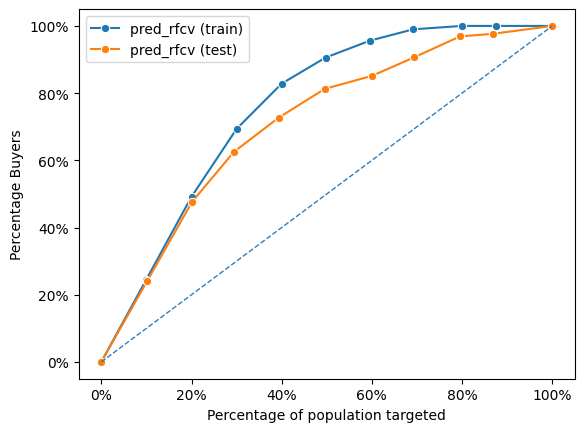

In [27]:
dct = {
    "train": titanic[titanic.training == 1],
    "test": titanic[titanic.training == 0],
}
fig = rsm.gains_plot(dct, rvar="survived", lev="Yes", pred="pred_rfcv")

In [28]:
titanic.loc[titanic.training == 1, "pred_rfcv"] = clf_rfcv.predict()["prediction"]

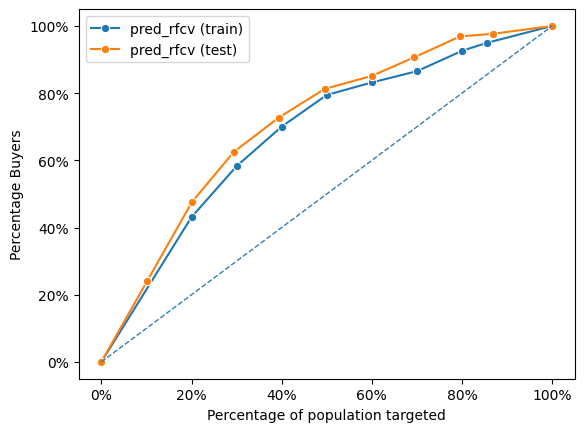

In [29]:
dct = {
    "train": titanic[titanic.training == 1],
    "test": titanic[titanic.training == 0],
}
fig = rsm.gains_plot(dct, rvar="survived", lev="Yes", pred="pred_rfcv")

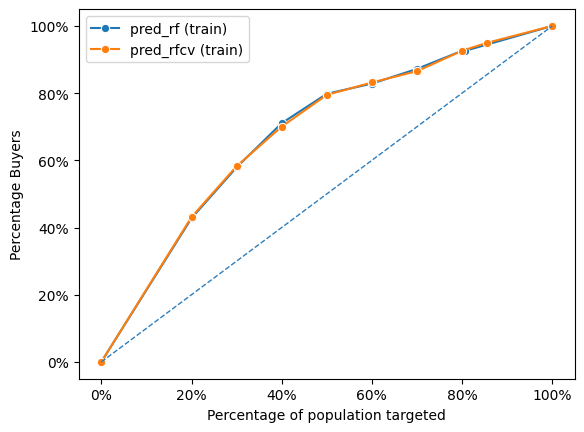

In [30]:
fig = rsm.gains_plot(
    {"train": titanic[titanic.training == 1]}, rvar="survived", lev="Yes", pred=["pred_rf", "pred_rfcv"]
)

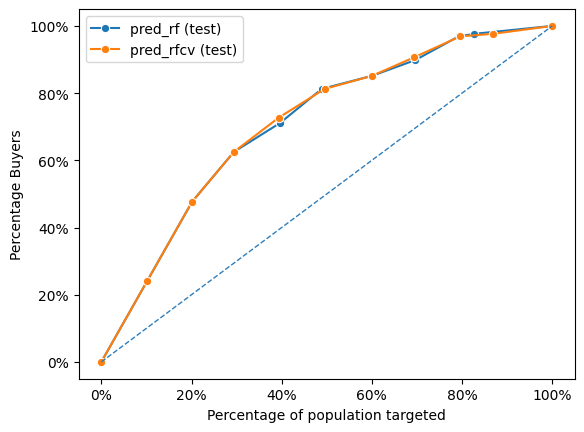

In [31]:
fig = rsm.gains_plot(
    {"test": titanic[titanic.training == 0]}, rvar="survived", lev="Yes", pred=["pred_rf", "pred_rfcv"]
)

In [54]:
if rsm.__version__ < "1.4.0":
    raise ValueError("Update pyrsm to 1.4.0 or higher")

scoring = {"AUC": "roc_auc", "accuracy": "accuracy"}
cv = rsm.model.cross_validation(clf_rf, "clf_rf", param_grid, scoring)

The best parameters are: {'max_features': 2, 'n_estimators': np.int64(300)}
The best model fit score is: 0.7948350617753795
The GirdSearchCV model fit estimates:
    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
7       0.213378      0.009481         0.010467        0.006464   
9       0.324711      0.005316         0.010719        0.000242   
8       0.283808      0.012315         0.009687        0.001212   
6       0.156632      0.009688         0.005541        0.000875   
1       0.146338      0.020248         0.007156        0.002738   

   param_max_features  param_n_estimators  \
7                   2                 300   
9                   2                 500   
8                   2                 400   
6                   2                 200   
1                   1                 200   

                                     params  split0_test_AUC  split1_test_AUC  \
7  {'max_features': 2, 'n_estimators': 300}         0.805814         0.825969   
9

In [36]:
# test script for issue https://github.com/scikit-learn/scikit-learn/issues/30675
# restrict sklearn version to 1.5.2 or older to avoid this bug
# import numpy as np
# import pandas as pd
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.inspection import PartialDependenceDisplay

# np.random.seed(42)
# n_samples = 1000
# age = np.random.normal(35, 10, n_samples)
# smoker = np.random.choice([0, 1], n_samples, p=[0.7, 0.3])
# prob_disease = 1 / (1 + np.exp(-(age - 35) / 10 - 2 * smoker))
# heart_disease = (np.random.random(n_samples) < prob_disease).astype(int)
# df = pd.DataFrame({"age": age, "smoker": smoker, "heart_disease": heart_disease})
# X = df[["age", "smoker"]]
# y = df["heart_disease"]

# rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
# rf_model.fit(X, y)

# pdp_age = PartialDependenceDisplay.from_estimator(rf_model, X, features=[0, 1])